<a href="https://colab.research.google.com/github/Hanzlah10/CFA/blob/main/CFA_Major_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Explaining using SHAP:


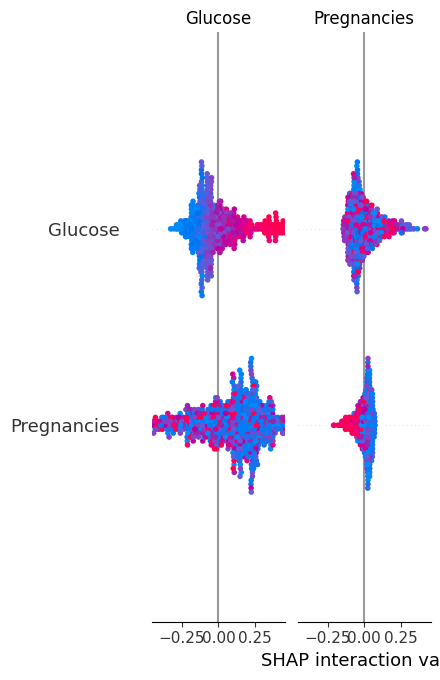

1. Analyzing Original Data Distribution


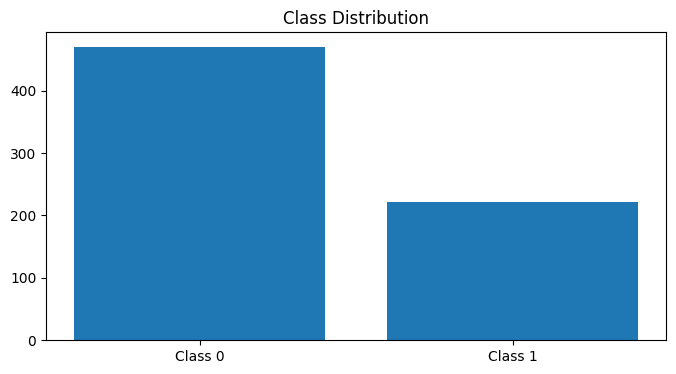

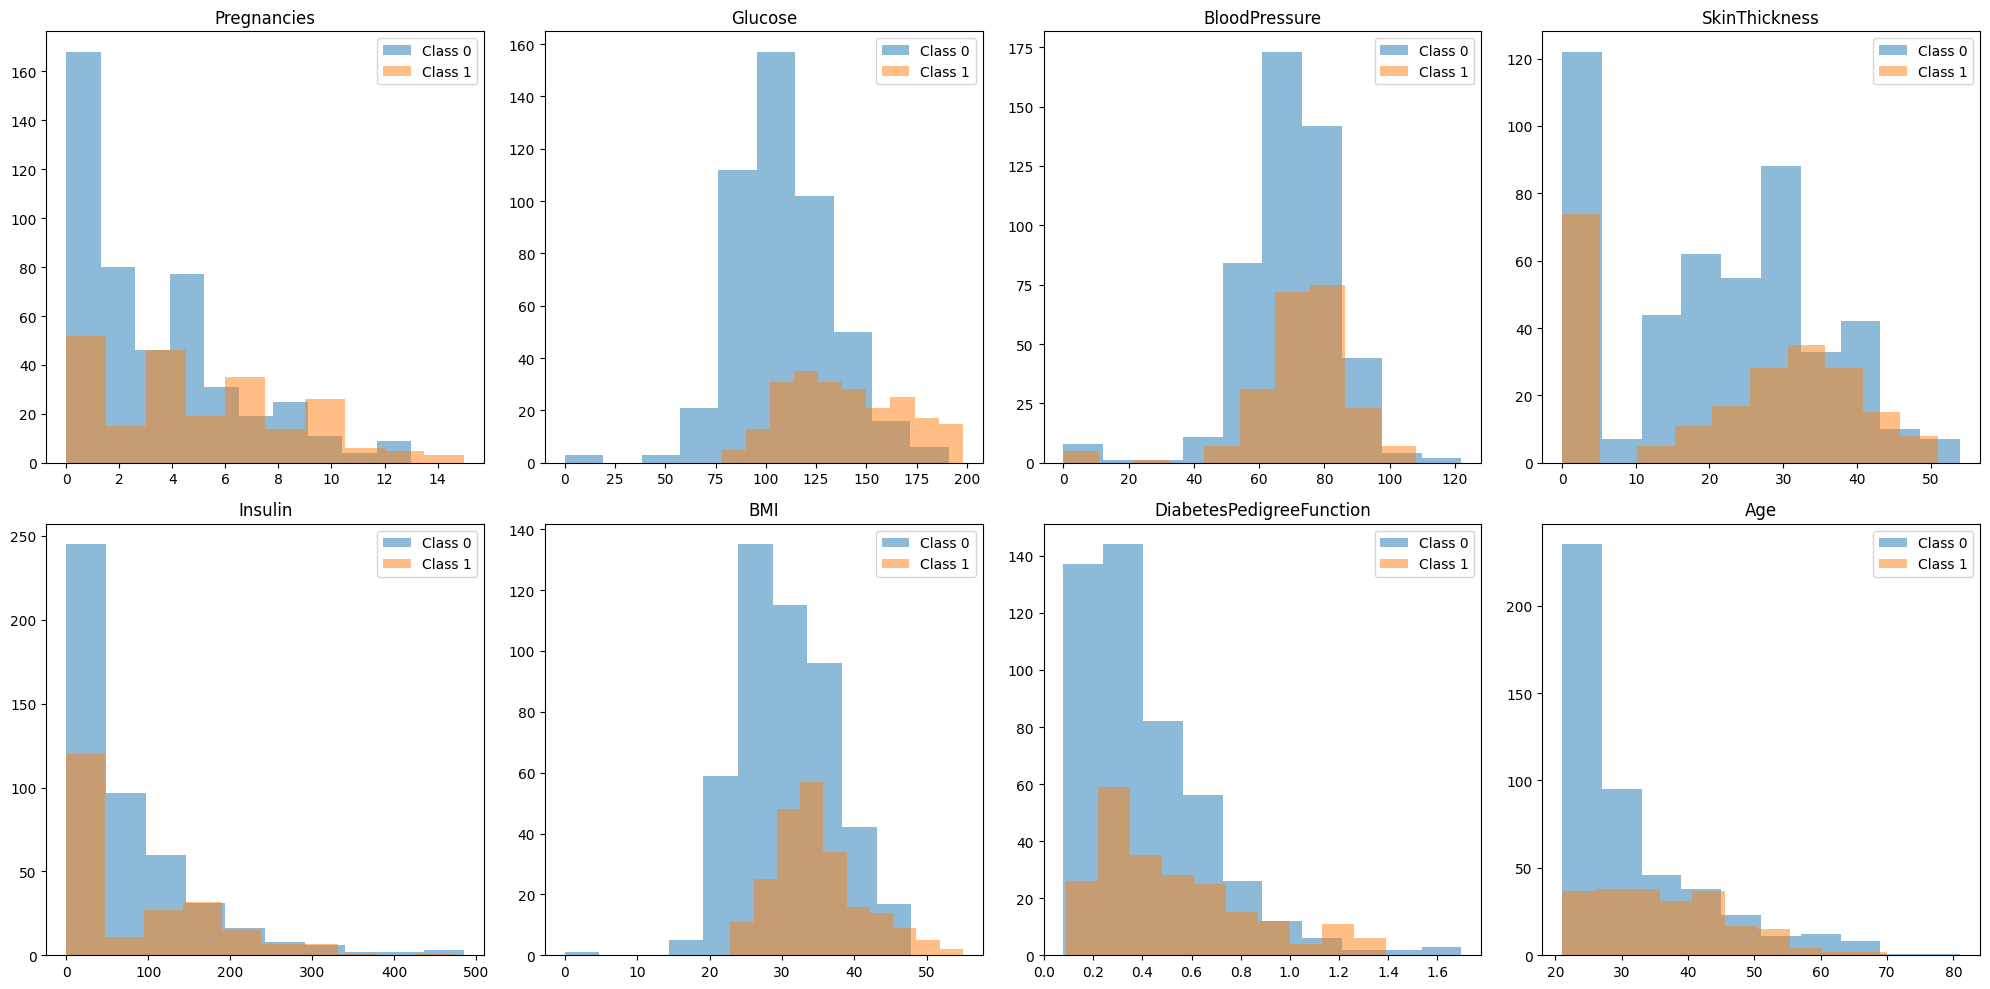


2. Selecting Important Features


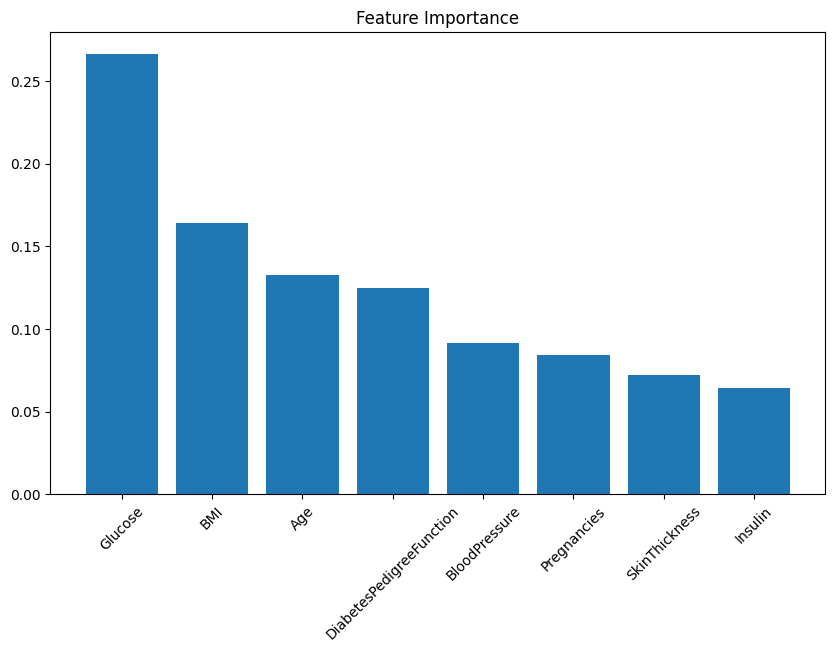


Feature Importance Scores:
Glucose: 0.2663
BMI: 0.1640
Age: 0.1326
DiabetesPedigreeFunction: 0.1248
BloodPressure: 0.0914
Pregnancies: 0.0843
SkinThickness: 0.0721
Insulin: 0.0644

Tolerance levels for important features:
Glucose: 5.9246
BMI: 1.3126
Age: 2.1888
DiabetesPedigreeFunction: 0.0568
BloodPressure: 3.0623
Pregnancies: 0.6504
SkinThickness: 3.0396
Insulin: 18.0565

Class distribution:
Majority class: 470
Minority class: 221

Generated 121 synthetic instances

3. Visualizing Results
Principal Component 1:
  SkinThickness: 0.5629
  Insulin: 0.5430
  BMI: 0.3572
  Age: -0.3117
  Pregnancies: -0.2911
  DiabetesPedigreeFunction: 0.2389
  Glucose: 0.1378
  BloodPressure: 0.0530
Principal Component 2:
  Age: 0.5441
  Pregnancies: 0.4782
  BloodPressure: 0.4498
  Glucose: 0.3994
  BMI: 0.2904
  DiabetesPedigreeFunction: 0.1145
  SkinThickness: 0.0933
  Insulin: 0.0854


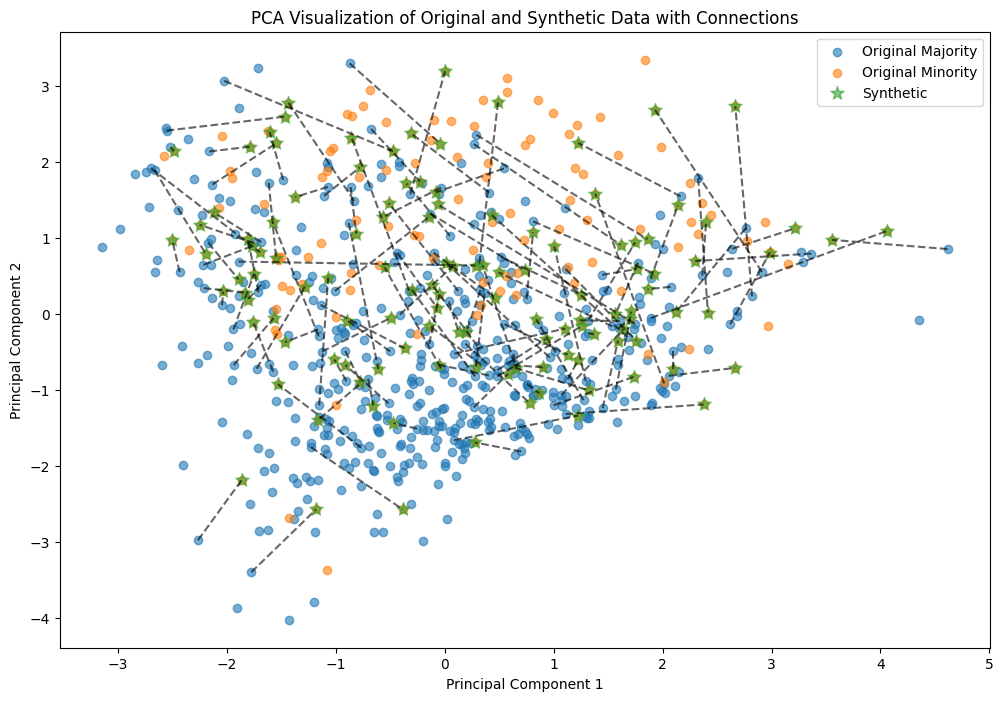


Table with 20 examples of synthetic data and changes made:
    Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0           6.0    148.0           72.0           35.0      0.0  33.6   
1           8.0    183.0           64.0            0.0      0.0  23.3   
2           3.0     78.0           50.0           32.0     88.0  31.0   
3           5.0    166.0           72.0           19.0    175.0  25.8   
4           7.0    100.0            0.0            0.0      0.0  30.0   
5           7.0    107.0           74.0            0.0      0.0  29.6   
6           1.0    115.0           70.0           30.0     96.0  34.6   
7           9.0    119.0           80.0           35.0      0.0  29.0   
8          11.0    143.0           94.0           33.0    146.0  36.6   
9          10.0    125.0           70.0           26.0    115.0  31.1   
10          7.0    147.0           76.0            0.0      0.0  39.4   
11          3.0    158.0           76.0           36.0    245.0 

In [2]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import NearestNeighbors
import shap
from sklearn.ensemble import RandomForestClassifier, IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import NearestNeighbors
import shap
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

def analyze_data_distribution(X, y, feature_names):
    """Show class distribution and feature importance"""
    # Class distribution
    plt.figure(figsize=(8, 4))
    unique, counts = np.unique(y, return_counts=True)
    plt.bar(['Class ' + str(i) for i in unique], counts)
    plt.title('Class Distribution')
    plt.show()

    # Feature distributions
    fig, axes = plt.subplots(2, 4, figsize=(20, 10))
    for i, (ax, name) in enumerate(zip(axes.ravel(), feature_names)):
        for label in [0, 1]:
            ax.hist(X[y == label, i], alpha=0.5, label=f'Class {label}')
        ax.set_title(name)
        ax.legend()
    plt.tight_layout()
    plt.show()

def get_important_features(X, y, feature_names):
    """Get feature importance using Random Forest"""
    rf = RandomForestClassifier(n_estimators=100, random_state=42)
    rf.fit(X, y)

    # Plot feature importance
    importance = rf.feature_importances_
    indices = np.argsort(importance)[::-1]

    plt.figure(figsize=(10, 6))
    plt.title('Feature Importance')
    plt.bar(range(X.shape[1]), importance[indices])
    plt.xticks(range(X.shape[1]), [feature_names[i] for i in indices], rotation=45)
    plt.show()

    # Print importance scores
    print("\nFeature Importance Scores:")
    for idx in indices:
        print(f"{feature_names[idx]}: {importance[idx]:.4f}")

    return indices[importance[indices] > 0.05]

def visualize_results_with_connections(X_original, X_synthetic, y_original, feature_names, used_indices):
    """Visualize original and synthetic data using PCA and show connections"""
    # Combine all data
    X_combined = np.vstack([X_original, X_synthetic])

    # Apply PCA
    scaler = StandardScaler()
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(scaler.fit_transform(X_combined))

    # Split back into original and synthetic
    X_pca_orig = X_pca[:len(X_original)]
    X_pca_synt = X_pca[len(X_original):]

    # Print feature contributions for the first two principal components
    for i, component in enumerate(pca.components_[:2], start=1):
        sorted_indices = np.argsort(np.abs(component))[::-1]
        sorted_features = [(feature_names[idx], component[idx]) for idx in sorted_indices]
        print(f"Principal Component {i}:")
        for feature, contribution in sorted_features:
            print(f"  {feature}: {contribution:.4f}")

    # Plot original and synthetic points
    plt.figure(figsize=(12, 8))
    plt.scatter(X_pca_orig[y_original == 0, 0], X_pca_orig[y_original == 0, 1],
                label='Original Majority', alpha=0.6)
    plt.scatter(X_pca_orig[y_original == 1, 0], X_pca_orig[y_original == 1, 1],
                label='Original Minority', alpha=0.6)
    plt.scatter(X_pca_synt[:, 0], X_pca_synt[:, 1],
                label='Synthetic', marker='*', s=100, alpha=0.6)

    # Draw lines connecting original majority points to their synthetic counterparts
    majority_indices = np.where(y_original == 0)[0]
    for syn_idx, maj_idx in enumerate(used_indices):
        plt.plot([X_pca_orig[majority_indices[maj_idx], 0], X_pca_synt[syn_idx, 0]],
                 [X_pca_orig[majority_indices[maj_idx], 1], X_pca_synt[syn_idx, 1]], 'k--', alpha=0.6)

    plt.legend()
    plt.title('PCA Visualization of Original and Synthetic Data with Connections')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.show()

def generate_counterfactuals(X, y, feature_names, fd=2, tol=0.2):
    """Main CFA function"""
    print("1. Analyzing Original Data Distribution")
    analyze_data_distribution(X, y, feature_names)

    print("\n2. Selecting Important Features")
    important_features = get_important_features(X, y, feature_names)
    X_important = X[:, important_features]

    # Calculate tolerance
    tolerance = tol * np.std(X_important, axis=0)
    print("\nTolerance levels for important features:")
    for i, feat_idx in enumerate(important_features):
        print(f"{feature_names[feat_idx]}: {tolerance[i]:.4f}")

    # Separate classes
    majority_mask = y == 0
    majority_data = X_important[majority_mask]
    minority_data = X_important[~majority_mask]

    majority_indices = np.where(majority_mask)[0]
    print(f"\nClass distribution:")
    print(f"Majority class: {len(majority_data)}")
    print(f"Minority class: {len(minority_data)}")

    # Generate synthetic instances
    synthetic_instances = []
    used_indices = []
    majority_indices_used = []

    # Find pairs using nearest neighbors
    nn = NearestNeighbors(n_neighbors=1)
    nn.fit(majority_data)

    for min_instance in minority_data:
        dist, maj_idx = nn.kneighbors([min_instance])
        maj_idx = maj_idx[0][0]

        if maj_idx not in used_indices:
            diff = np.abs(min_instance - majority_data[maj_idx])
            if np.sum(diff <= tolerance) >= fd:
                synthetic = majority_data[maj_idx] + (min_instance - majority_data[maj_idx])
                synthetic_instances.append(synthetic)
                used_indices.append(maj_idx)
                majority_indices_used.append(majority_indices[maj_idx])

    if not synthetic_instances:
        print("\nNo synthetic instances generated. Try adjusting parameters.")
        return X, y, None

    synthetic_instances = np.array(synthetic_instances)

    # Create full synthetic instances
    full_synthetic = np.zeros((len(synthetic_instances), X.shape[1]))
    for i, maj_idx in enumerate(used_indices):
        full_synthetic[i] = X[majority_indices[maj_idx]]
        full_synthetic[i, important_features] = synthetic_instances[i]

    print(f"\nGenerated {len(synthetic_instances)} synthetic instances")

    # Visualize results
    print("\n3. Visualizing Results")
    visualize_results_with_connections(X, full_synthetic, y, feature_names, used_indices)

    # Create a table with 20 examples of synthetic data
    synthetic_data_table = pd.DataFrame(full_synthetic[:20], columns=feature_names)
    majority_data_table = pd.DataFrame(X[majority_indices_used[:20]], columns=feature_names)

    differences = synthetic_data_table - majority_data_table
    differences.columns = [col + '_change' for col in differences.columns]

    table_with_changes = pd.concat([synthetic_data_table, differences], axis=1)

    print("\nTable with 20 examples of synthetic data and changes made:")
    print(table_with_changes)

    # Return augmented dataset
    X_augmented = np.vstack([X, full_synthetic])
    y_augmented = np.concatenate([y, np.ones(len(full_synthetic))])
    synthetic_labels = np.concatenate([np.zeros(len(X)), np.ones(len(full_synthetic))])

    return X_augmented, y_augmented, synthetic_labels


def remove_outliers(X, y):
    """Remove outliers using Isolation Forest"""
    # Fit the Isolation Forest model
    iso_forest = IsolationForest(contamination=0.1, random_state=42)
    yhat = iso_forest.fit_predict(X)

    # Select all rows that are not outliers
    mask = yhat != -1
    return X[mask], y[mask]
def explain_with_shap(X, model, feature_names):
    """Use SHAP to explain model predictions"""
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X)

    if isinstance(shap_values, list):
        shap_values_class_1 = shap_values[1]
    else:
        shap_values_class_1 = shap_values

    shap.summary_plot(shap_values_class_1, X, feature_names=np.array(feature_names))

    shap.initjs()
    shap.force_plot(shap_values_class_1[0], X[0], feature_names=feature_names)

def run_example_with_shap_updated():
    # Load data
    url = 'https://raw.githubusercontent.com/jbrownlee/Datasets/master/pima-indians-diabetes.csv'
    columns = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome']

    data = pd.read_csv(url, names=columns)
    # data = data.sample(n=200, random_state=42)

    # Separate features and target
    X = data.drop('Outcome', axis=1).values
    y = data['Outcome'].values
    feature_names = list(data.drop('Outcome', axis=1).columns)

    # Remove outliers
    X, y = remove_outliers(X, y)

    # Fit Random Forest model
    rf = RandomForestClassifier(n_estimators=100, random_state=42)
    rf.fit(X, y)

    # Explain using SHAP
    print("Explaining using SHAP:")
    explain_with_shap(X, rf, feature_names)

    # Run CFA (Counterfactual Augmentation)
    X_augmented, y_augmented, synthetic_labels = generate_counterfactuals(
        X, y, feature_names, fd=2, tol=0.2
    )

    print("\nFinal Results:")
    print("-" * 69)
    print(f"Original dataset shape (after outlier removal): {X.shape}")
    print(f"Augmented dataset shape: {X_augmented.shape}")
    print(f"Number of synthetic instances: {np.sum(synthetic_labels)}")

# Now you can run the updated example with the outlier removal included
run_example_with_shap_updated()
